# Resumen 6/8/2024

La opción de "proyectar" la sombra de la nube según el ángulo del sol y altura de nubes (Ver ### Proyección nubes), no es mala pero tiene 2 problemas: que tapa posibles píxeles de muestra y que además, la estimación de la distancia a donde están las sombras (ie: la distancia en el plano (i.e.: sup. terrestre) desde la nube hasta su sombra).

## 3 clusters

Una alternativa que exploré, es usar clasificación no supervisada (clusters) para diferenciar 3 clases: sombras, nubes y agua. El ejemplo lindo (5/4/23; ver abajo), muestra un caso en el que funciona muy bien. El problema es que en otros ejemplos, ya no es tan lindo (20/4/23: no hay nubes y tiene floraciones; 8/4/2023: tiene nubes, sombras y floraciones algales).

Los ejemplos no lindos llevan a clasificaciones que no separan bien lo que se precisa. A veces se confunden sombras con floraciones, a veces el yi, que tiene un color más oscuro (el 8/4/23)

Ya de por sí esta aproximación requiere además otra complejidad, ya que hay que determinar si verdaderamente están las clases esperadas, a qué elemento corresponde cada clase (Agua, nube, sombra... floracion?), para finalmente crear la máscara correspondiente.

De todas maneras, apenas llegué a probar un manojo de combinaciones de índices (usando normalizedDifference, principalmente) y cantidad de clases para el KMean. Me enfoqué principalmente en tratar de que todo encaje en 3 clases (Agua, Sombra, Nubes), pero tal vez esto no tenga sentido cuando hay floraciones, en cuyo caso, capaz que sería mejor usar 4 clases (así como capaz que tampoco tendría mucho sentido, para un día en que no haya ni una sola nube o floración, tener más de 1 clase; de hecho todavía no sé bien cuál sería la mejor manera de resolver estas situaciones...).

En principio empecé a probar con valores de bandas así nomás, pero los índices suelen ser mejores, porque eliminan problemas de sesgo. No se me ocurrieron posibles mejores índices. No necesariamente hay.

Parte de los análisis los hice en R... buscando posibles métricas que me separaran los datos como yo quiero. Los scripts son

- R/test.R
- R/claes_clusters_x_indices.R
- R/pruebas_categorias.R

La fechas analizadas (Palmar):

fecha_muestra = "2023-04-05" # Agua / Nubes / Sombras
fecha_muestra = "2023-04-20" # Agua / Floraciones
fecha_muestra = '2023-04-08' # Agua / Nubes / Sombras / Floraciones

**Ejemplo "lindo" con 3 clusters:**

- fecha_muestra = "2023-04-05" 
- bandas, b = ["ndwi", "ndbr", "ndbg"]

## 2 Instancias con 2 clusters

En este modo, primero saco las nubes con una máscara. Esto lo logro ajustando 2 clusters a lo que es agua. Luego de aplicar esta máscara, vuelvo a ajustar para 2 clusters, los cuales serían agua y sombra.

Funcionó razonablemente bien, aunque es engorroso y además no fue intentado en fechas "difíciles" (sólo se probo en la fecha del ejemplo lindo: 5/4/23).


## Enlaces a cosas que pueden servir

https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel/sentinel-2/ 
https://custom-scripts.sentinel-hub.com/sentinel-2/ndwi/
https://custom-scripts.sentinel-hub.com/sentinel-2/fapar/ 
https://custom-scripts.sentinel-hub.com/sentinel-2/false_color_infrared/

https://sentiwiki.copernicus.eu/web/s2-applications 

https://www.sciencedirect.com/science/article/pii/S2666017220300092 

https://en.wikipedia.org/wiki/Luminous_efficiency_function 


# Detección de sombras 

*: El "ejemplo nubes" sale de acá: https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless

### Para ver las bandas del FC2_with_cloud_mask:

Alturas de nubes con S5: https://code.earthengine.google.com/448f9425387963431ec1ac567b206bc5; (https://code.earthengine.google.com/?scriptPath=users%2Fjumanbar%2FpruebasRN%3AAlturaNubes)

## Autenticación

In [115]:
import os
import ee
from google.auth.transport.requests import AuthorizedSession


##################################################################
# CREDENTIALS =======
print('\nEnviando credenciales a la nube ...')

PROJECT = 'pruebas-gee-00' # Ej: pruebas-engine-00
# SERVICE_ACCOUNT = 'pruebas-gee-jmb@pruebas-gee-00.iam.gserviceaccount.com'
SERVICE_ACCOUNT = 'jumanbar@gmail.com'
KEY = os.path.join(os.getcwd(), 'debian-key.json')
rest_api_url = 'https://earthengine.googleapis.com/v1beta/projects/{}/table:computeFeatures'

print('\LLAVE:', KEY)

# PROBLEMAS ACA / INICIO
credentials = ee.ServiceAccountCredentials(SERVICE_ACCOUNT, KEY)
scoped_credentials = credentials.with_scopes(
    ['https://www.googleapis.com/auth/cloud-platform'])

session = AuthorizedSession(scoped_credentials)
ee.Initialize(credentials)
# PROBLEMAS ACA / FIN
###################################################################
# DRIVE
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

from oauth2client.service_account import ServiceAccountCredentials
gauth = GoogleAuth()
scope = ['https://www.googleapis.com/auth/drive']
gauth.credentials = ServiceAccountCredentials.from_json_keyfile_name('debian-key.json', scopes = scope)
drive = GoogleDrive(gauth)
###################################################################


Enviando credenciales a la nube ...
\LLAVE: c:\Users\juan.barreneche\Documents\gee_automatizacion\debian-key.json


## Variables y tal

In [116]:
"""
id_zona = 1
zona = 'PALMAR'
geom = ee.FeatureCollection('users/brunogda/zonas_palmar_represa_dis')\
    .first()\
    .geometry()

mask_ndwi = ee.Image(0)
lo_ndwi = ee.Image(0)
"""

from math import tan, pi, log10, ceil
from pprint import pprint
import numpy as np
import json
from inifun import *
import calfun as cf
id_zona = 5
nzonas = 60
isValidZoneID(id_zona, nzonas)

def getAssetString(nzonas, id_zona):    
    if nzonas == 7:
        out = getAssetFromIdZona(id_zona)
    else:
        out = getAssetFromIdZona60(id_zona)
    return out

asset_string = getAssetString(nzonas, id_zona)

print(f'\tAsset string: {asset_string}')

# Polígono:
geom = ee.FeatureCollection(asset_string).first().geometry()

p = [10, 50, 90]
cloud_perc  = 50 # 25
cloud_perc2 = 50 # 25
# MAX_CLOUD_PROBABILITY = 10
MAX_CLOUD_PROBABILITY = 40
percentil_stat_base_nubes = 70;
escala_proy_nubes = 50

ini_date = '2023-04-01'
ini_date_o3 = '2023-04-01'
end_date = '2023-05-01'

# Cloud shadows
BUFFER = 50
cf.escala_proy_nubes = 50
cf.cbh_percentil = percentil_stat_base_nubes

# COPIAR VARIABLES AL NAMESPACE DE calfun:
cf.zona = 'RN60Z'
cf.id_zona = id_zona
cf.geom = geom
cf.p = p

cf.cloud_perc = cloud_perc
cf.cloud_perc2 = cloud_perc2
cf.MAX_CLOUD_PROBABILITY = MAX_CLOUD_PROBABILITY
cf.escala_proy_nubes = escala_proy_nubes

cf.end_date = end_date
cf.ini_date = ini_date
cf.ini_date_o3 = ini_date_o3

fprop = cf.filterProperties(60, 5)
print(f'\tid_zona:  {id_zona}')
print(f'\tnzonas:   {nzonas}')
print(f'\tProperty: {fprop["prp"]}')
print(f'\tValue:    {fprop["val"]}')

	Asset string: users/brunogda/RN60/05_rn
	id_zona:  5
	nzonas:   60
	Property: MGRS_TILE
	Value:    21HVD


# Distancia de la nube a su sombra (demo)

In [117]:
from datetime import datetime as dt, timezone

MSI_source = 'COPERNICUS/S2_HARMONIZED'
MSI = ee.ImageCollection(MSI_source)
print(f'ini: {ini_date} - fin: {end_date}')
common_criteria = ee.Filter.And(ee.Filter.bounds(geom),
                                ee.Filter.date(ini_date, end_date))

x = MSI.filter(common_criteria).filter(ee.Filter.eq(fprop['prp'], fprop['val']))
a = x.first().date().getInfo()['value']
print(f'Fecha de primer imagen de la colección S2:\n\t{dt.fromtimestamp(a/1000)}')
a2 = x.first().get('GENERATION_TIME').getInfo()

nubes = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_CLOUD')\
        .filterDate(x.first().date().advance(-4, 'hour'), x.first().date().advance(4, 'hour'))

clouds_height = cf.cloudsBaseHeightByDate(x.first().date())
print(f'Altura de nubes (percentil {cf.cbh_percentil}): {clouds_height.getInfo():.2f}m')

d = cf.shadowDistFromClouds(x.first())

# print(datetime.fromtimestamp(x.first().date().getInfo()))
print(f'Distancia en el plano de la sombra a la nube: {d.getInfo():.2f}m => {ceil(d.getInfo()/cf.escala_proy_nubes)} px')

ini: 2023-04-01 - fin: 2023-05-01
Fecha de primer imagen de la colección S2:
	2023-04-03 11:01:41.296000
Altura de nubes (percentil 70): 4659.88m
Distancia en el plano de la sombra a la nube: 4929.80m => 99 px


In [118]:
print(dt.fromtimestamp(1686997020000/1000))
print(dt.fromtimestamp(1655901773000/1000))
print(dt.fromtimestamp(1687010506681/1000))
print(dt.fromtimestamp(1687010506681/1000, timezone.utc))

2023-06-17 07:17:00
2022-06-22 09:42:53
2023-06-17 11:01:46.681000
2023-06-17 14:01:46.681000+00:00


## Armar image collections

In [119]:
# Sentinel multibanda
MSI_source = 'COPERNICUS/S2_HARMONIZED'    # Nuestro, original
MSI = ee.ImageCollection(MSI_source)
# Probabilidad de nubes:
S2_clouds = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')

print(f'ini: {ini_date} - fin: {end_date}')

# Filter input collections by desired data range and region.
common_criteria = ee.Filter.And(ee.Filter.bounds(geom),
                                ee.Filter.date(ini_date, end_date))

S2_clouds = S2_clouds.filter(common_criteria)

# Esto se fija en qué imágenes de la colección hay pocas nubes en total y se
# queda con esas:
S2_mask = (
    MSI
    .filter(common_criteria)
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', "less_than", cloud_perc2)
)

# FILTER Sentinel 2 collection
FC2 = S2_mask.filter(ee.Filter.eq(fprop["prp"], fprop["val"])).map(cf.maskEdges)

cf.printDatesFromImageCollection(FC2, 'FC2')

## NDWI
## Sirve con S2_HARMONIZED y S2_SR_HARMONIZED
ndwi = S2_mask.median().normalizedDifference(['B3', 'B8'])
hi_ndwi = ndwi.select('nd').gte(0.2)
lo_ndwi = ndwi.select('nd').lt(0.2)
mask_ndwi = hi_ndwi.updateMask(hi_ndwi)

stats_ndwi = ndwi.reduceRegion(
    reducer = ee.Reducer.min().combine(
        reducer2=ee.Reducer.max(),
        sharedInputs=True
    ),
    geometry=cf.area_nubes_rn,
    scale=100
)
# pprint(stats_ndwi.getInfo()) # {'nd_max': 0.550044286979628, 'nd_min': -0.7329525169582292}

# FILTER Sentinel 2 collection
# FC2 = MSI.filterDate(ini_date, end_date)\
#     .filterBounds(geom)\
#     .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', "less_than", cloud_perc)\
#     .filter(ee.Filter.eq(prp, val))

# Join S2 SR with cloud probability dataset to add cloud mask.
FC2_with_cloud_mask = ee.ImageCollection(
    ee.Join.saveFirst('cloud_mask').apply(
        primary = FC2,
        secondary = S2_clouds,
        condition = ee.Filter.equals(
            leftField = 'system:index',
            rightField = 'system:index')
        )
    )

############## DESCOMENTAR ESTO:
S2_cloud_masked = FC2_with_cloud_mask.map(cf.add_cld_shdw_mask)

ini: 2023-04-01 - fin: 2023-05-01
Lista de fechas en FC2:
- 2023-04-05 10:51:49.050000
- 2023-04-08 11:01:44.244000
- 2023-04-10 10:51:46.252000
- 2023-04-13 11:01:41.951000
- 2023-04-15 10:51:47.079000
- 2023-04-18 11:01:43.669000
- 2023-04-20 10:51:44.393000
- 2023-04-28 11:01:43.670000


In [120]:
# fecha_muestra = '2023-04-20' # Sin nubes
# import geemap
# m = geemap.Map()
# satimage = FC2.filterDate(f'{fecha_muestra}T00:00:01', f'{fecha_muestra}T23:59:59').first()
# test_clouds = S2_clouds.filterDate(f'{fecha_muestra}T00:00:01', f'{fecha_muestra}T23:59:59').first()
# cf.printBandNames(test_clouds)
# test = S2_cloud_masked.filterDate(f'{fecha_muestra}T00:00:01', f'{fecha_muestra}T23:59:59').first()
# cf.printBandNames(test)

# m.add_layer(satimage, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1}, 'FC2', True, 1)
# m.set_zoom(12)
# m.set_center(lat=-33.07859699518517, lon=-57.49969482521876)

# m.add_layer(test.select('probability'), {'min': 0, 'max': 1}, 'Cloud prob', True, 1)
# display(m)

## Proyección nubes

Esta parte es extraída de una de las funciones (ver [Nuevas](#scrollTo=Nuevas)). Lo puse acá porque quería ver cómo funcionaba eso de la proyección y la función `directionalDistanceTransform`

In [179]:
# ! C:/Users/juan.barreneche/AppData/Local/Programs/Python/Programs/Python/Python310/python.exe -m pip install geemap
import geemap
# fecha_muestra = "2023-04-05" # Agua / Nubes / Sombras
# fecha_muestra = "2023-04-20" # Agua / Floraciones
fecha_muestra = '2023-04-08' # Agua / Nubes / Sombras / Floraciones
# satimage = FC2.filterDate(f'{fecha_muestra}T00:00:01', f'{fecha_muestra}T23:59:59').first()
sr = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
    .filter(common_criteria).filter(ee.Filter.eq(fprop['prp'], fprop['val']))\
    .filterDate(f'{fecha_muestra}T00:00:01', f'{fecha_muestra}T23:59:59').first()

# pprint(sr.getInfo())
satimage = FC2_with_cloud_mask.filterDate(f'{fecha_muestra}T00:00:01', f'{fecha_muestra}T23:59:59').first()
nubes = cf.add_cloud_bands(satimage)
test = S2_cloud_masked.filterDate(f'{fecha_muestra}T00:00:01', f'{fecha_muestra}T23:59:59').first()
img_shadow = ee.Image(cf.add_shadow_bands(test))
# d = cf.shadowDistFromClouds(test).getInfo()
# test = S2_cloud_masked.first()
cf.printBandNames(test)
maxdist = ceil(d/cf.escala_proy_nubes)
m = geemap.Map()
m.set_zoom(12)
m.set_center(lat=-33.09039099883797, lon=-57.306747436523445)
m.add_layer(satimage, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1}, 'FC2', True, 1)
m.add_layer(sr.select('SCL').randomVisualizer(), {}, 'SCK', True, 1)
# m.add_layer(test, None, 'test Clouds mask', False, 1)
m.add_layer(ndwi.select('nd'), {'min': -1, 'max': 1}, 'NDWI', True, 1) # {'nd_max': 0.550044286979628, 'nd_min': -0.7329525169582292}
m.add_layer(mask_ndwi.mask(), None, 'Water mask', False, 1)
m.add_layer(img_shadow.select('cloud_transform'), {'min': 0, 'max': maxdist, 'palette': ['yellow', 'red']}, 'DISTANCE', True, 1)
m.add_layer(nubes.select('clouds').Not(), None, 'Clouds', False, 1)
m.add_layer(test.mask().Not(), None, 'test Clouds mask', False, 1)
display(m)

B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B10, B11, B12, QA10, QA20, QA60, MSK_CLASSI_OPAQUE
MSK_CLASSI_CIRRUS, MSK_CLASSI_SNOW_ICE, probability, clouds, cloud_transform


Map(center=[-33.09039099883797, -57.306747436523445], controls=(WidgetControl(options=['position', 'transparen…

In [122]:
def sampleS2Image2JSON(img, filename='muestra'):
    p = [0] * 101
    for i in range(100):
        p[i + 1] = i + 1
    
    stats = img.reduceRegion(
        reducer=ee.Reducer.percentile(p),
        scale=10,
        bestEffort=True
    )
    valores = stats.getInfo()
    out = {}
    bands = img.bandNames().getInfo()
    for bnd in bands:
        out[bnd] = []
        for j in range(100):
            element = bnd + '_p' + str(j + 1)
            out[bnd].append(valores[element])
            # print(element)

    with open(f'{filename}.json', 'w') as m:
        json.dump(out, m)

# Stats

No sé dónde meter esto.

In [180]:
p = [0, 100]
stats = muestra.reduceRegion(
    reducer=ee.Reducer.percentile(p),
    # reducer=ee.Reducer.min().combine(ee.Reducer.max()),
    # geometry=cf.area_nubes_rn,
    scale=10,
    bestEffort=True
)
pprint(stats.getInfo())

stats2 = agua.reduceRegion(
    reducer=ee.Reducer.percentile(p),
    # reducer=ee.Reducer.min().combine(ee.Reducer.max()),
    # geometry=cf.area_nubes_rn,
    scale=10,
    bestEffort=True
)
# pprint(stats2.getInfo())




{'B2_p0': 2.293714391061701,
 'B2_p100': 3.35583543222972,
 'B3_p0': 2.7061668773594647,
 'B3_p100': 3.982042558602868,
 'B4_p0': 1.1925966097408744,
 'B4_p100': 2.7123915942641474,
 'nd_date_p0': -0.2600584400988986,
 'nd_date_p100': 0.5460017196904557}


# 3 clusters

Acá voy con 3 índices normalizados:

- NDWI: bandas B3 - B8
- "NDBR": bandas B2 - B4 ("Blue - Red")
- "NDBG": bandas B2 - B3 ("Blue - Green")

Tanto NDBR como NDBG parecen ser buenos diferenciando las 3 categorías, en general:

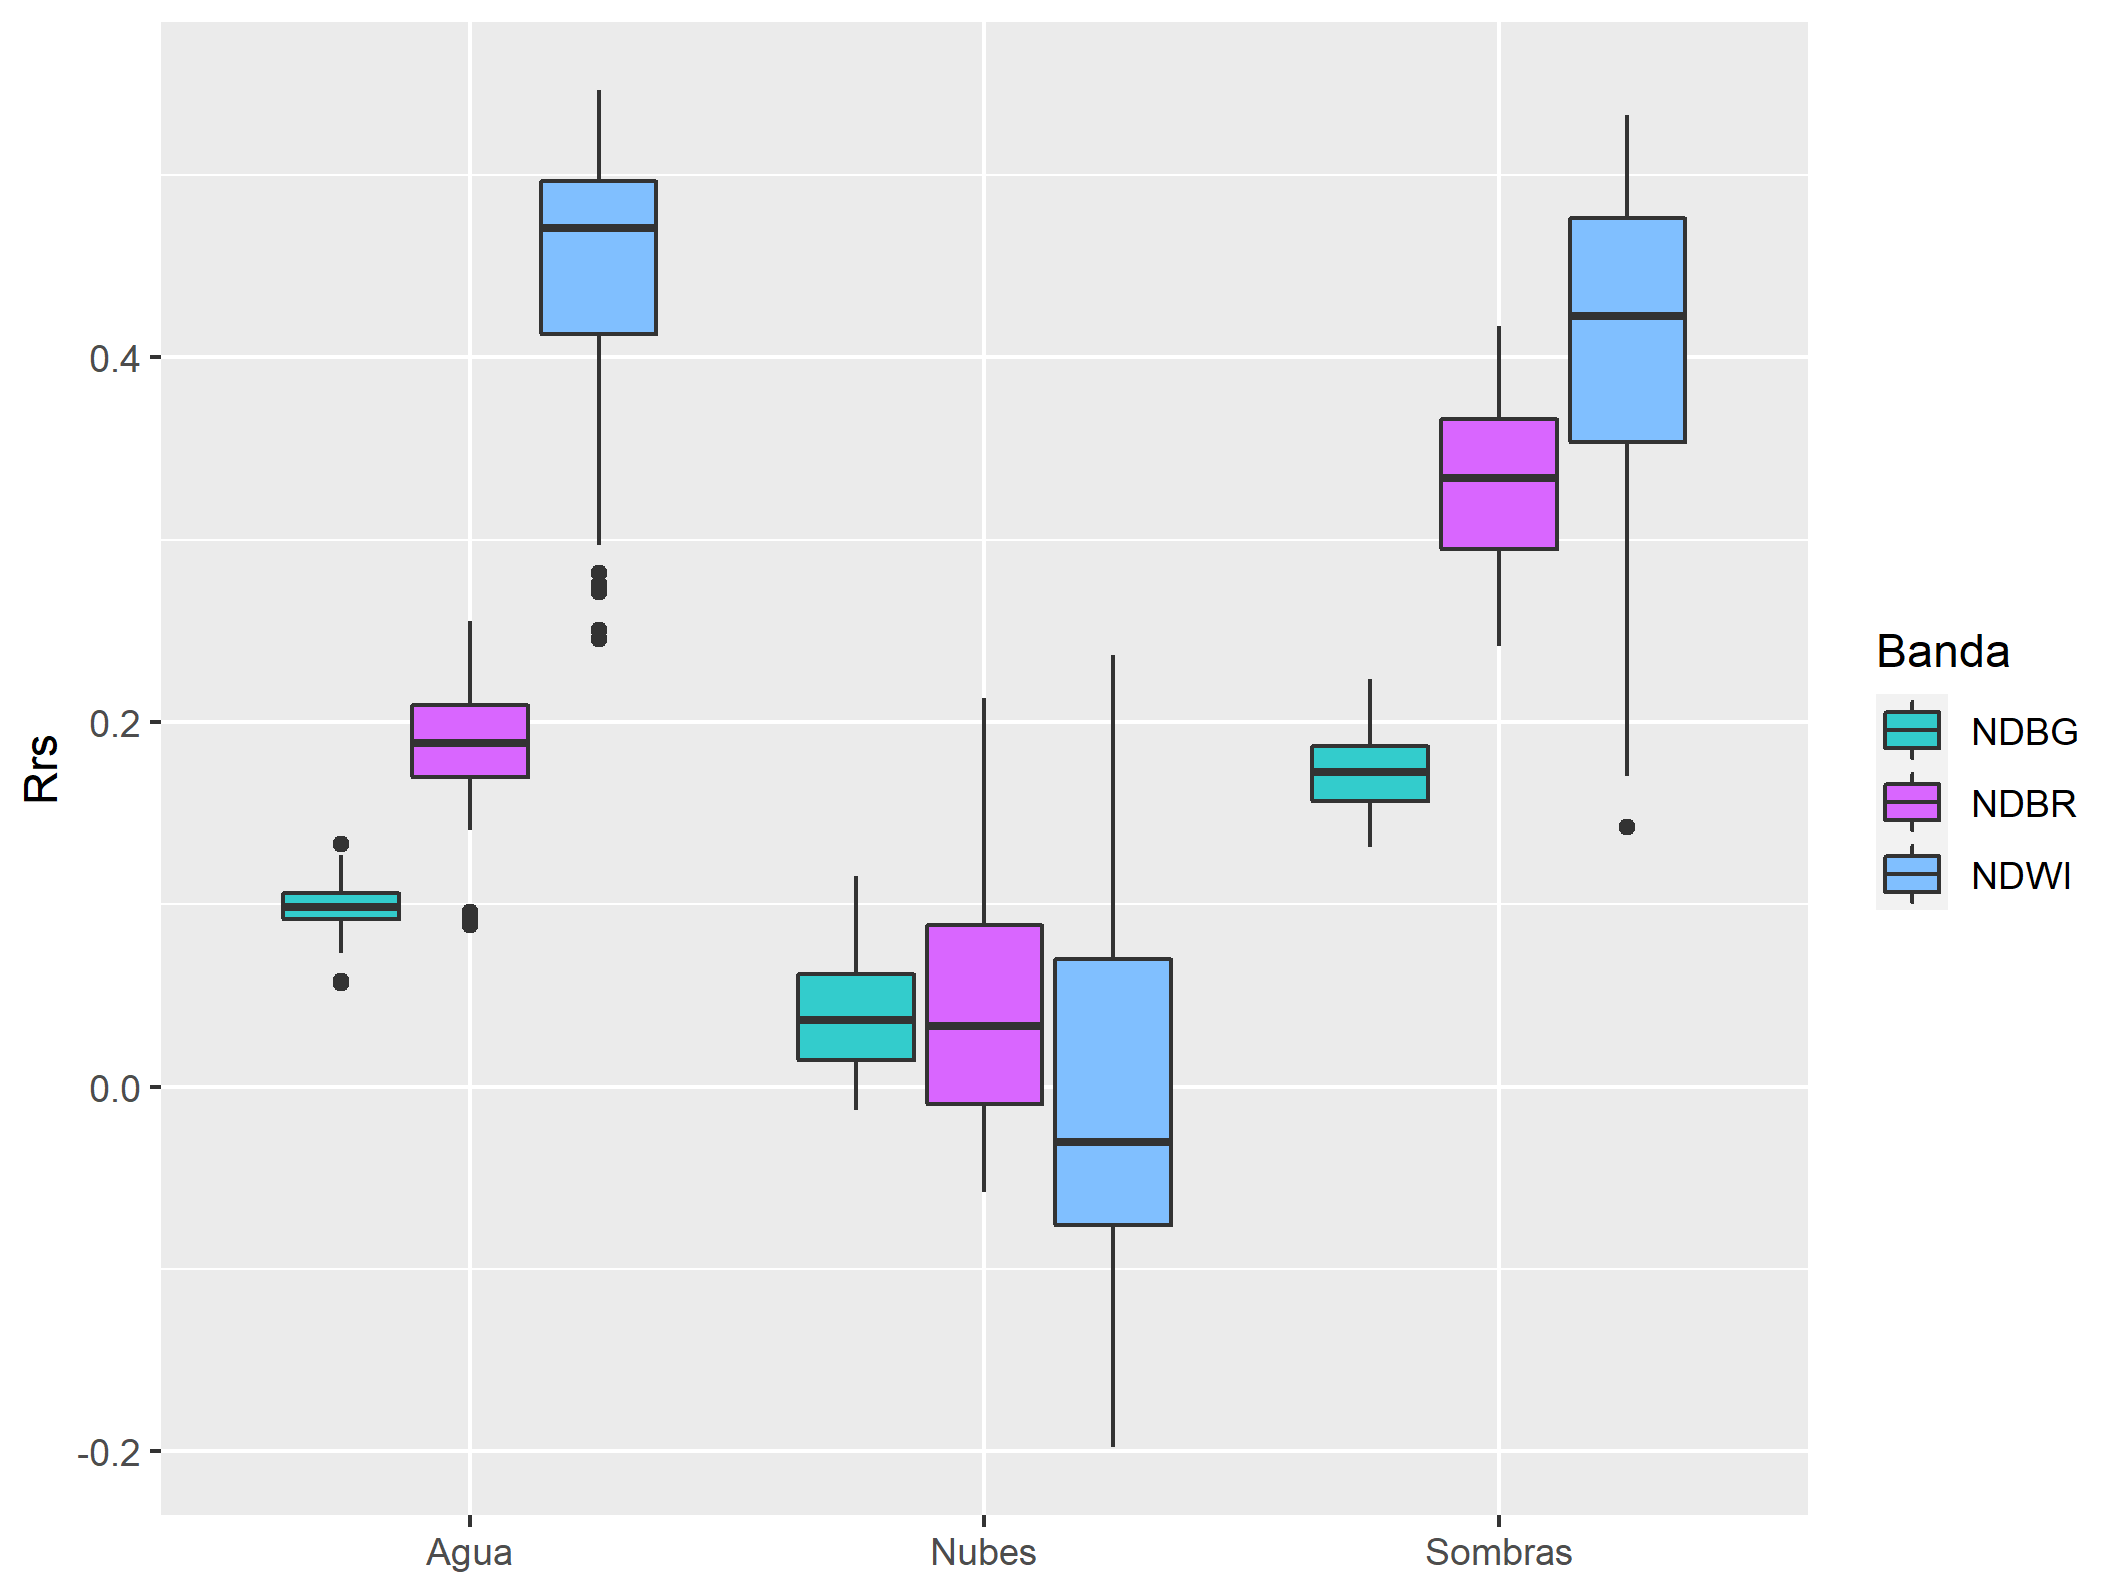

(Boxplot creado con una muestra de 100 puntos por clase, para la fecha 5/4/2023, las cuales se obtuvieron con un clustering de KMeans usando las 3 bandas mencionadas.)

NDBR parece un poco más apto en la gráfica, para diferenciar las 3 clases. Tiene las mismas tendencias que NDBG, pero más acentuadas.

NDWI es muy bueno separando nubes de todo el resto, pero no para separar agua de sombras.

Esta muestra es "fácil". Todavía no llegué a ver qué pasa en casos raros: cuando está todo tapado de nubes, o cuando hay mucha floración algal.

In [171]:
# https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel/sentinel-2/
nclases = 3

feat_test = (
    satimage
    .addBands(satimage.normalizedDifference(['B3',  'B8']).rename('ndwi'))
    .addBands(satimage.normalizedDifference(['B5',  'B4']).rename('ndci'))
    .addBands(satimage.normalizedDifference(['B8',  'B4']).rename('ndvi'))
    .addBands(satimage.normalizedDifference(['B4',  'B8']).rename('ivdn'))
    .addBands(satimage.normalizedDifference(['B8',  'B2']).rename('nube'))
    .addBands(satimage.normalizedDifference(['B2',  'B4']).rename('ndbr')) # Separar agua de sombras
    .addBands(satimage.normalizedDifference(['B2',  'B3']).rename('ndbg'))
    .addBands(satimage.normalizedDifference(['B3', 'B11']).rename('ndsi'))
    .select(bandas)
    .updateMask(mask_ndwi)
)

agua = satimage.updateMask(mask_ndwi)
bandas = ["ndwi", "ndci", "ndvi", "ivdn", "nube", "ndbr", "ndbg", "ndsi"]
b = ['ndvi', 'ndbg', 'ndbr', 'ndsi']
random_sample_test = feat_test.select(b).sample(
    numPixels = 100000,
    scale = 10
)
clusterer_test = ee.Clusterer.wekaKMeans(nclases, distanceFunction='Euclidean').train(random_sample_test)
ClasNoSup = feat_test.select(b).cluster(clusterer_test)
p = [0, 100]
stats = feat_test.reduceRegion(
    reducer=ee.Reducer.percentile(p),
    scale=10,
    bestEffort=True
)
# pprint(stats.getInfo())

Idea: los percentiles más altos y bajos de los índices NDBR y NDBG, van a indicar los extremos de sombras y nubes, así que por ahí se puede ver la forma de embocarle al cluster correcto...

El percentil más alto de NDWI va a ser agua casi siempre.

In [172]:
m = geemap.Map()
m.set_zoom(12)
m.set_center(lat=-33.0904, lon=-57.30675)
m.add_layer(satimage.select(['B4', 'B3', 'B2']), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 4000, 'gamma': 1.1}, 'Color natural', True, 1)
m.add_layer(satimage.select(['B8', 'B4', 'B2']), {'bands': ['B8', 'B4', 'B2'], 'min': 0, 'max': 6000, 'gamma': 1.1}, 'Falso Color', True, 1)
m.add_layer(satimage.select(['B8', 'B6', 'B5']), {'bands': ['B8', 'B6', 'B5'], 'min': 0, 'max': 6000, 'gamma': 1.1}, 'Color raro', True, 1)
for b in bandas:
    m.add_layer(feat_test.select(b), {'min': -1, 'max': 1}, b.upper(), False, 1)
m.add_layer(ClasNoSup.randomVisualizer(), {}, 'Clasif. no sup', False, 1)
display(m)

Map(center=[-33.0904, -57.30675], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Searc…

In [16]:
cf.printBandNames(feat_test)

ndwi, ndbr, ndbg


In [95]:
# https://gis.stackexchange.com/a/455479/9857
props = feat_test.bandNames().add('cluster')
para_means = random_sample_test.cluster(clusterer_test)
cluster_centers_test = ee.List(
    para_means.reduceColumns(
        # ee.Reducer.mean().repeat(2).group(2),
        ee.Reducer.mean().repeat(3).group(3), # count = #bands
        props
    ).get('groups')
)

# pprint(cluster_centers_test.get('groups').getInfo())
pprint(cluster_centers_test.getInfo())


[{'group': 0,
  'mean': [0.19692152568265278, 0.23331408083411725, 0.05561344099563676]},
 {'group': 1,
  'mean': [0.34597148154119844, 0.2862418089551621, 0.15682035768904265]},
 {'group': 2,
  'mean': [0.44840165881850064, 0.16778770642438923, 0.08827370639917621]},
 {'group': 3,
  'mean': [0.4817936469793086, 0.21707939281515787, 0.09026482475713052]}]


Estos promedios de los clusters aparentemente están en el mismo orden que las bandas: NDWI, NDBR y NDBG ('group' refiere al cluster)

In [96]:
sampleS2Image2JSON(feat_test, f'features_test_{fecha_muestra}')
# sampleS2Image2JSON(feat_test, 'features_test_20230420')
muestra_x_clase = feat_test.addBands(ClasNoSup.select('cluster')).stratifiedSample(100, 'cluster')
# pprint(muestra_x_clase.getInfo())

In [97]:
import time
estado = ''
start = time.time()
filename = f'sampleClusters_{fecha_muestra}'
tarea = ee.batch.Export.table.toDrive(
    collection=muestra_x_clase,
    description=filename,
    fileFormat='CSV'
)
tarea.start()
while estado != 'COMPLETED':
    estado = tarea.status()['state']
    end = time.time()
    print(f'Creating file: {filename}.csv -' +
            f' Status:\t{estado} ({str(round(end - start, 1))}s)',
            end='\r')

In [98]:
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
drive_file_index = -1
for i, file in enumerate(file_list):
    print('%i - title: %s, id: %s' % (i, file['title'], file['id']))
    if file['title'] == f'{filename}.csv':
        drive_filename = file['title']
        drive_file_index = i

if drive_file_index >= 0:
    file = file_list[0]
    drive_filename = file['title']
    file.GetContentFile(drive_filename, mimetype='text/csv')

0 - title: sampleClusters_2023-04-08.csv, id: 1G_G2HmAX5Bvuh2EL98UHO62H4IZHYPT1
1 - title: ee_exports, id: 1SuS3BmfnXdUjuV-2Edm1U01U1IZ96bDC


In [99]:
if drive_file_index >= 0:
    print(f'Deleting\t...\t{drive_filename}')
    file.Delete()

Deleting	...	sampleClusters_2023-04-08.csv


# 2 Pasadas de 2 clusters

In [371]:
muestra_ndwi = agua.select('nd_date')
random_sample_ndwi = muestra_ndwi.sample(
    numPixels = 100000,
    scale = 10
)

clusterer_ndwi = ee.Clusterer.wekaKMeans(2, distanceFunction='Euclidean').train(random_sample_ndwi)
ClasNoSup_ndwi = muestra_ndwi.cluster(clusterer_ndwi)

m = geemap.Map()
m.set_zoom(12)
m.set_center(lat=-33.09039099883797, lon=-57.306747436523445)
m.add_layer(satimage.select(['B4', 'B3', 'B2']), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3177, 'gamma': 1.1}, 'Color natural', True, 1)
m.add_layer(muestra, {'bands': ['B4', 'B3', 'B2'], 'min': 2.28, 'max': 3.6, 'gamma': 1.1}, 'Color verdosiento', False, 1)
m.add_layer(agua.select('nd_date'), {'min': -0.17198636504493336, 'max': 0.5388513513513513}, 'NDWI', False, 1)
m.add_layer(agua.select('nd_date').gte(0.4), {}, 'Date water', False, 1)
m.add_layer(ClasNoSup_ndwi.randomVisualizer(), {}, 'Clasif. no sup', False, 1)
mask_water_not_cloud = ClasNoSup_ndwi.select("cluster").eq(0)
agua_not_cloud = agua.updateMask(mask_ndwi.And(mask_water_not_cloud))
m.add_layer(agua_not_cloud.mask(), None, 'mask_water_not_cloud', True, 1)
m.add_layer(agua_not_cloud.select(['B4', 'B3', 'B2']), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3177, 'gamma': 1.1}, 'Color natural MASK', True, 1)
display(m)

Map(center=[-33.09039099883797, -57.306747436523445], controls=(WidgetControl(options=['position', 'transparen…

### Para ver las bandas del FC2_with_cloud_mask:

Alturas de nubes con S5: https://code.earthengine.google.com/448f9425387963431ec1ac567b206bc5; (https://code.earthengine.google.com/?scriptPath=users%2Fjumanbar%2FpruebasRN%3AAlturaNubes)

In [323]:
cf.printBandNames(agua)

B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B10, B11, B12, QA10, QA20, QA60, MSK_CLASSI_OPAQUE
MSK_CLASSI_CIRRUS, MSK_CLASSI_SNOW_ICE, nd, nd_date


In [364]:
muestra_final = (
    agua_not_cloud
    .addBands(agua_not_cloud.normalizedDifference(['B2', 'B4']).rename('nd_br'))
    # .addBands(agua_not_cloud.normalizedDifference(['B2', 'B3']).rename('nd_bg'))
    # .select(['nd_br', 'nd_bg'])
    .select(['nd_br'])
)
# pprint(muestra_final.getInfo())

In [346]:
muestra_final_alternativa = (
    agua_not_cloud
    .addBands(agua.updateMask(mask_ndwi.And(mask_water_not_cloud)).select('B8'))
    .addBands(agua_not_cloud.normalizedDifference(['B2', 'B8']).rename('nd_bnir'))
    .addBands(agua_not_cloud.normalizedDifference(['B2', 'B3']).rename('nd_bg'))
    .select(['nd_bnir', 'nd_bg'])
)

La alternativa en realidad no funciona bien. El otro funciona mucho mejor (está basado en los contrastes que percibe el ojo humano!!)

In [365]:
random_sample_final = muestra_final.sample(numPixels = 100000, scale = 10)
clusterer_final = ee.Clusterer.wekaKMeans(2, distanceFunction='Euclidean').train(random_sample_final)
ClasNoSup_final = muestra_final.cluster(clusterer_final)

In [367]:
# https://gis.stackexchange.com/a/455479/9857
props = muestra_ndwi.bandNames().add('cluster')
para_means = random_sample_ndwi.cluster(clusterer_ndwi)
cluster_centers_ndwi = para_means.reduceColumns(
    # ee.Reducer.mean().repeat(2).group(2),
    ee.Reducer.mean().repeat(1).group(1),
    props
)
pprint(cluster_centers_ndwi.get('groups').getInfo())

[{'group': 0, 'mean': [0.4338404664963742]},
 {'group': 1, 'mean': [-0.009964469150481884]}]


El cluster `mean` más alto es el que correpsonde al agua. Este creo que siempre va a ser fácil, aún cuando no haya nubes, supongo.

Alturas de nubes con S5: https://code.earthengine.google.com/448f9425387963431ec1ac567b206bc5; (https://code.earthengine.google.com/?scriptPath=users%2Fjumanbar%2FpruebasRN%3AAlturaNubes)

In [366]:
m = geemap.Map()
m.set_zoom(12)
m.set_center(lat=-33.09039099883797, lon=-57.306747436523445)
m.add_layer(satimage.select(['B4', 'B3', 'B2']), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3177, 'gamma': 1.1}, 'Color natural', True, 1)
# m.add_layer(agua_not_cloud.updateMask(agua_not_cloud.mask().eq(0)), None, 'mask_water_not_cloud', True, 1)
m.add_layer(agua_not_cloud.mask(), None, 'mask_water_not_cloud', False, 1)
m.add_layer(ClasNoSup_final.randomVisualizer(), {}, 'Clasif. no sup', False, 1)
mask_water_not_cloud_or_shadow = ClasNoSup_final.select("cluster").eq(0)
agua_not_cloud_or_shadow = agua.updateMask(mask_water_not_cloud_or_shadow)
m.add_layer(agua_not_cloud_or_shadow.mask(), None, 'agua_not_cloud_or_shadow', True, 1)
m.add_layer(agua_not_cloud_or_shadow.select(['B4', 'B3', 'B2']), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3177, 'gamma': 1.1}, 'Color natural MASK', True, 1)
display(m)

Map(center=[-33.09039099883797, -57.306747436523445], controls=(WidgetControl(options=['position', 'transparen…

In [369]:
# https://gis.stackexchange.com/a/455479/9857
props = muestra_final.bandNames().add('cluster')
para_means = random_sample_final.cluster(clusterer_final)
cluster_centers_final = para_means.reduceColumns(
    # ee.Reducer.mean().repeat(2).group(2),
    ee.Reducer.mean().repeat(1).group(1),
    props
)
pprint(cluster_centers_final.get('groups').getInfo())


[{'group': 0, 'mean': [0.18753764875050707]},
 {'group': 1, 'mean': [0.334437988870679]}]


Acá el grupo correspondiente al agua es el que tiene el valor más bajo de `mean` (azul y rojo están relativamente altos ambos; en la sombra el rojo es el que más baja.)

In [ ]:
cluster_centers_final

In [182]:
areas = (
    ee.Image.pixelArea().addBands(ClasNoSup)
    .reduceRegion(
        reducer=ee.Reducer.sum().unweighted().group(1),
        geometry=cf.area_nubes_rn,
        crs=ClasNoSup.projection(),
        scale=10,
        maxPixels=1e6,
        bestEffort=True,
        tileScale=1
    )
)

print(areas.getInfo())


{'groups': [{'group': 0, 'sum': 2149469.890625}, {'group': 1, 'sum': 162541188.4765625}]}


In [134]:
out = {}
bands = muestra.bandNames().getInfo()
for bnd in bands:
    out[bnd] = []
    for j in range(100):
        element = bnd + '_p' + str(j + 1)
        out[bnd].append(histogram[element])
        # print(element)


import json
with open('muestra.json', 'w') as m:
    json.dump(out, m)

In [140]:
# Demonstrate extracting pixels from an image as features with
# ee.Image.sample(), and show how the features are aligned with the pixels.

# An image with one band of elevation data.
image = ee.Image('CGIAR/SRTM90_V4')
vis_min = 1620
vis_max = 1650
m = geemap.Map()
m.add_layer(image, {'min': vis_min, 'max': vis_max}, 'SRTM')

# Region to sample.
region = ee.Geometry.Polygon(
    [[
        [-110.006, 40.002],
        [-110.006, 39.999],
        [-109.995, 39.999],
        [-109.995, 40.002],
    ]],
    None,
    False,
)
# Show region on the map.
m.set_center(-110, 40, 16)

m.add_layer(ee.FeatureCollection([region]).style(color='00FF0022'))

# Perform sampling convert image pixels to features.
samples = image.sample(
    region=region,
    # Default (False) is no geometries in the output.
    # When set to True, each feature has a Point geometry at the center of the
    # image pixel.
    geometries=True,
    # The scale is not specified, so the resolution of the image will be used,
    # and there is a feature for every pixel. If we give a scale parameter, the
    # image will be resampled and there will be more or fewer features.
    #
    # scale=200,
)


def scale_point_size(feature):
  elevation = feature.getNumber('elevation')
  point_size = elevation.unitScale(vis_min, vis_max).multiply(15)
  feature.set('style', {'pointSize': point_size})
  return feature


# Visualize sample data using ee.FeatureCollection.style().
styled = samples.map(scale_point_size).style(
    color='000000FF',
    fillColor='00000000',
    styleProperty='style',
    neighborhood=6,  # increase to correctly draw large points
)
m.add_layer(styled)
display(m)

# Each sample feature has a point geometry and a property named 'elevation'
# corresponding to the band named 'elevation' of the image. If there are
# multiple bands they will become multiple properties. This will print:
#
# geometry: Point (-110.01, 40.00)
# properties:
#   elevation: 1639
display(samples.first())

Map(center=[40, -110], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…